### Module 5A - Basics of Geometric Raytracing

Written for AIFS.   
Copyright 2023 Tarek Zohdi, Emre Mengi. All rights reserved.

In this assignment, you will be introduced to the basics of light-based simulation methods.

In [29]:
############################################### Import Packages ##########################################
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import time
import csv
import os
from copy import deepcopy
from matplotlib import animation
from matplotlib import rc
plt.rcParams.update({'font.size': 18})
from scipy.stats import uniform
import pandas as pd
from IPython.display import display, HTML
plt.rcParams['animation.embed_limit'] = 2**128

### **Problem 1:** Theory-Based Exercises ###

Answer the following questions *prior* to coding the assignment to better understand the background physics and mathematics that govern the given models. You **may** solve these problems by hand **and/or** using computational tools such as *Python* etc. Please include all handwritten work and code used to solve each problem.

**Problem 1.1:** For a parametrized test surface given by 

\begin{equation}
        x_{3}=2+A\left(\sin \frac{2 \omega_{1} \pi x_{1}}{L_{1}}\right) \sin \left(\frac{2 \omega_{2} \pi x_{2}}{L_{2}}\right)
\end{equation}
    
Analytically solve for the gradient of the surface.

**ANSWER:** Components of the gradient can be computed as:

\begin{equation}
    \nabla F=\frac{\partial F}{\partial x_1} \boldsymbol{e}_1+\frac{\partial F}{\partial x_2} \boldsymbol{e}_2+\frac{\partial F}{\partial x_3} \boldsymbol{e}_3
\end{equation}


$G\left(x_1, x_2\right)$ in parametric can be computed by:

\begin{equation}
    F\left(x_1, x_2, x_3\right)=G\left(x_1, x_2\right)-x_3=0
\end{equation}

The gradient can be rewritten as:

\begin{equation}
    \nabla F=\frac{\partial G}{\partial x_1} \boldsymbol{e}_1+\frac{\partial G}{\partial x_2} \boldsymbol{e}_2-\boldsymbol{e}_3
\end{equation}

For the parametrized test surface given:

\begin{equation}
    \begin{gathered}
x_3=2+A \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right) \\
\nabla F=\frac{\partial\left(2+A \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right)\right)}{\partial x_1} \boldsymbol{e}_1+\frac{\partial\left(2+A \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right)\right)}{\partial x_2} \boldsymbol{e}_2-\boldsymbol{e}_3 \\
=\left(\frac{2 A \omega_1 \pi}{L_1}\right) \cos \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right) \boldsymbol{e}_1+\left(\frac{2 A \omega_2 \pi}{L_2}\right) \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \cos \left(\frac{2 \omega_2 \pi x_2}{L_2}\right) \boldsymbol{e}_2-\boldsymbol{e}_3
\end{gathered}
\end{equation}

**Problem 1.2:** Write down the Forward Euler equation for time discretization. Explain all the terms.

**ANSWER**: The forward Euler discretization for position and velocity terms are as follows:

\begin{equation}
 \bm{r}_i(t +\Delta t) \; \dot{=} \; \bm{r}_i(t) +  \bm{v}_i(t)\Delta t
\end{equation}

Since the speed of light is constant, the only PDE we are solving is to update our ray position.

<img src="drone_lidar.png" width="400" />

**Problem 1.3:** Consider a drone scanning a surface, seen in above figure. Denote the position of the drone as $(x_0,y_0)$, ground as $(x_g,y_g)$, and the final position of the returned ray as $(x_f,y_f)$. If the lidar system on the drone emits a ray with an angle $\theta_i$, analytically solve for the final position of the ray, $(x_f,y_f)$, in terms of $h_0$, $h_g$, $\theta_i$, drone $(x_0,y_0)$ and ground positions $(x_g,y_g)$. Also, calculate the time it takes for the light ray to reach $(x_f,y_f)$ if $||v_{ray}|| = c$. Assume the ground is where the ray intersects with the surface is flat.

**ANSWER:** The distance between the surface and the drone is $d=h_0-h_g$. Given the ray is emitted at an angle $\theta_i$ when the drone is at $\left(x_0, y_0\right)$. The drone collects the ray at $\left(x_f, y_f\right)$. It can be seen that $y_f=y_0$.
\\*

The lateral distance traveled by the light is:
\begin{equation}
    L=2 *\left(h_0-h_g\right) \tan \theta_i
\end{equation}

Then, the final position of the drone is:

\begin{equation}
    \left(x_f, y_f\right)=\left(x_0+2 *\left(h_0-h_g\right) \tan \theta_i, y_0\right)
\end{equation}

The time of flight for the ray can be calculated using the total distance traveled by the ray:

\begin{equation}
    \begin{aligned}
& d_{t o t}=2 \sqrt{\left(\left(h_0-h_g\right) \tan \theta_i\right)^2+\left(h_0-h_g\right)^2}=2 \sqrt{\left(h_0-h_g\right)^2\left(\tan ^2 \theta_i+1\right)} \\
&=2 \sqrt{\left(h_0-h_g\right)^2 \sec ^2 \theta_i}=2\left(h_0-h_g\right) \sec \theta_i
\end{aligned}
\end{equation}

Then, the total time can be calculated using the speed of light:

\begin{equation}
    t_{f l i g h t}=\frac{d_{t o t}}{c}=\frac{2\left(h_0-h_g\right) \sec \theta_i}{c}
\end{equation}


### **Problem 2:** Coding Exercises ###  
Use the given python notebook template to complete the following coding exercises.

**Problem 2.1:** Define the constants used in the simulation. Use the variable glossary at the end of the assignment.

In [2]:
################################ Define Constants ##########################################

#free-space magn. permeability [Wb/(Am)]
mu_0 = 4*np.pi*1e-7  #FILL IN HERE

#free-space elec. permittivity [C/(Nm)]
eps_0 = 8.8542*1e-12  #FILL IN HERE

#speed of light [m/s]
c = 1/np.sqrt(mu_0*eps_0) #FILL IN HERE

#mu_hat: ratio of magn. permeability scattering/absorbing (mu_a)...
mu_hat = 1 #FILL IN HERE

# electric permitivity (chosen)
eps_hat = 25 #FILL IN HERE

# refractive index
n_hat = 10 #FILL IN HERE

**Problem 2.2:** Set up the first surface (surface A).

/var/folders/7m/8wrj_0b17ql_1p_x8v4tqdrw0000gn/T/ipykernel_44342/210513234.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


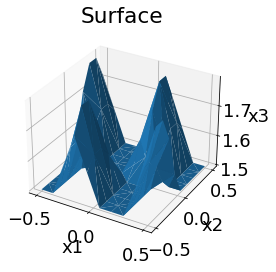

In [42]:
######################### Set up the surface (SURFACE A) ##########################################

# set up surface parameters
L1 = 1
L2 = 1
w1 = 1.5
w2 = 0.75
A = 0.3

# set up limits of test surface
test_lim = 0.5; 

# create grid of points using linspace
x1 = np.linspace(-test_lim,test_lim,10)
x2 = np.linspace(-test_lim,test_lim,10)

# create grid of points using meshgrid
[X1, X2] = np.meshgrid(x1,x2)

# reshape grid into a column vector
X1 = np.reshape(X1,[np.size(X1),1])
X2 = np.reshape(X2,[np.size(X2),1])

# write surface equation for surface a
X3 = 1.5 + A * np.sin(2 * w1 * np.pi * X1 / L1) * np.sin(2 * w2 * np.pi * X2 / L2) #FILL IN HERE
      
# Calculate normals

#surface A
#delF
delGx1 = A*(2*w1*np.pi/L1)*np.cos(2*w1*np.pi*X1/L1)*np.sin(2*w2*np.pi*X2/L2) #FILL IN HERE
delGx2 = A*(2*w2*np.pi/L2)*np.sin(2*w1*np.pi*X1/L1)*np.cos(2*w2*np.pi*X2/L2) #FILL IN HERE

delFx1 = delGx1
delFx2 = delGx2
delFx3 = np.ones([np.size(delGx1),1])*-1

gradF = np.hstack([delFx1, delFx2, delFx3])
magdelF = np.reshape(np.linalg.norm(gradF,2,1),(np.size(X1),1))

normal = - gradF / magdelF

for i in range(X3.size): #uncomment for surface a NORMAL + SURFACE POINT FIX
    if X3[i]-1.5 < 0:
        X3[i] = 1.5
        normal[i,0] = 0
        normal[i,1] = 0
        normal[i,2] = 1
        
   
# plot surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(X1[:,0], X2[:,0], X3[:,0], linewidth=0.2, antialiased=True)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
# label plot
plt.title('Surface')
plt.show()

**Problem 2.3:** Use Forward Euler time-stepping scheme to simulate a beam hitting the given test surfaces. (surface A).

In [39]:
########################## Create rays ##########################################

beam_initvel = np.array([0,0,-c]) #initial velocity of beam
beam_N = 100 #number of rays
beam_initH = 2 #initial height
beam_N = round(np.sqrt(beam_N))**2 # updated number of rays to have it square
print('Updated number of rays is:',beam_N)

#full beam grid
[beam_posx1,  beam_posx2] = np.meshgrid(np.linspace(-0.5,0.5,round(np.sqrt(beam_N))),np.linspace(-0.5,0.5,round(np.sqrt(beam_N)))) 

# reshape grid into a column vector
beam_posx1 = np.reshape(beam_posx1,[np.size(beam_posx1),1]) 
beam_posx2 = np.reshape(beam_posx2,[np.size(beam_posx2),1])
beam_posx3 = np.ones([beam_N,1]) * beam_initH

# set up initial velocity of beam
beam_vel1 = np.ones([beam_N,1])  * beam_initvel[0]
beam_vel2 = np.ones([beam_N,1])  * beam_initvel[1]
beam_vel3 = np.ones([beam_N,1])  * beam_initvel[2]

# Time-stepping
totaltime = 0.00000001 # simulation time
xi = 0.00000005 # time-stepping constant
dt = xi * beam_initH / np.sqrt(c) # time-step
Ntimestep = round(totaltime / dt) # number of time-steps

# initialize variables
IR = np.zeros([np.size(beam_posx1),1]) 
theta_i = np.zeros([np.size(beam_posx1),1])
X1_final = np.empty([np.size(beam_posx1),1])
X2_final = np.empty([np.size(beam_posx1),1])
X3_final = np.empty([np.size(beam_posx1),1])

# initialize animation variables
rayAnim = list() # list of ray objects
rayHit = list() # list of ray hit objects


for i in range(Ntimestep): # time-stepping loop
    
    #time-step announcer (every 100 time-steps)
    if i % 100 == 0:
        print('Time-step:',i,'/',Ntimestep)
        
    
    #update position
    beam_posx1 = beam_posx1 + beam_vel1 * dt
    beam_posx2 = beam_posx2 + beam_vel2 * dt
    beam_posx3 = beam_posx3 + beam_vel3 * dt
     
    for k in range(np.size(beam_posx1)): # loop over rays
        #check if below surface
        X3_calc = 1.5 + A*np.sin(2*w1*np.pi*beam_posx1[k]/L1)*np.sin(2*w2*np.pi*beam_posx2[k]/L2); #FILL IN HERE
        for z in range(np.size(X3_calc)):
            if X3_calc-1.5 < 0: # if below surface, set to surface
                X3_calc = 1.5 

        if beam_posx1[k] <= test_lim and beam_posx1[k] >= -test_lim and beam_posx2[k] <= test_lim and beam_posx2[k] >= -test_lim: # if within test limits
           if X3_calc>beam_posx3[k]: # if below surface
               if IR[k] == 0: # if not yet reflected
                    
                    # find normal and ray velocity vector
                    # Calculate normals
                    # delF
                    # surface a
                    delGx1 = A*(2*w1*np.pi/L1)*np.cos(2*w1*np.pi*beam_posx1[k]/L1)*np.sin(2*w2*np.pi*beam_posx2[k]/L2) #FILL IN HERE
                    delGx2 = A*(2*w2*np.pi/L2)*np.sin(2*w1*np.pi*beam_posx1[k]/L1)*np.cos(2*w2*np.pi*beam_posx2[k]/L2) #FILL IN HERE
                    
                    delFx1 = delGx1
                    delFx2 = delGx2
                    delFx3 = -1
                    
                    gradF = np.hstack([delFx1, delFx2, delFx3])
                    magdelF = np.linalg.norm(gradF,2)
                    
                    normal = - gradF / magdelF
                    
                    # surface a
                    if X3_calc == 1.5:
                        normal[0] = 0
                        normal[1] = 0
                        normal[2] = 1
                            
                    norm_k = normal # normal vector
                    beam_vel = np.hstack([beam_vel1[k], beam_vel2[k], beam_vel3[k]]) # ray velocity vector
                    theta_i = np.arccos(np.dot(norm_k,beam_vel)/c) # angle of incidence
                    if beam_vel3[k] <= 0: # if ray is going down
                        #record point of contact with surface
                        X1_final[k] = beam_posx1[k] 
                        X2_final[k] = beam_posx2[k]
                        X3_final[k] = beam_posx3[k]
                    
                        beam_vel = beam_vel - 2 * c * np.cos(theta_i) * norm_k # reflect ray

                        #update velocity
                        beam_vel1[k] = beam_vel[0]
                        beam_vel2[k] = beam_vel[1]
                        beam_vel3[k] = beam_vel[2]
                        #theta_i = np.pi - theta_i

                        #update IR
                        IR[k] = (np.abs(theta_i/n_hat) <= 1.)* \
                            (0.5*(((n_hat**2 * np.cos(theta_i) - (n_hat**2 - np.sin(theta_i)**2)**(0.5))/ \
                                    (n_hat**2 * np.cos(theta_i) + (n_hat**2 - np.sin(theta_i)**2)**(0.5)))**2 +\
                                   (((np.cos(theta_i) - (n_hat**2 - np.sin(theta_i)**2)**(0.5))/ \
                                     (np.cos(theta_i) + (n_hat**2 - np.sin(theta_i)**2)**(0.5)))**2)))+ \
                                (np.abs(theta_i/n_hat) > 1.)**1.



    if i % 50  == 0:
  
        #assign current loc, vel, and energy left in rays in an array

        rayInfo = np.hstack([beam_posx1, beam_posx2, beam_posx3, beam_vel1, beam_vel2, beam_vel3])

        # write into rayAnim list the current x,y,z positions of each ray and velocity vector
        rayAnim.append(rayInfo)

Updated number of rays is: 100
Time-step: 0 / 1731
Time-step: 100 / 1731
Time-step: 200 / 1731
Time-step: 300 / 1731
Time-step: 400 / 1731
Time-step: 500 / 1731
Time-step: 600 / 1731
Time-step: 700 / 1731
Time-step: 800 / 1731
Time-step: 900 / 1731
Time-step: 1000 / 1731
Time-step: 1100 / 1731
Time-step: 1200 / 1731
Time-step: 1300 / 1731
Time-step: 1400 / 1731
Time-step: 1500 / 1731
Time-step: 1600 / 1731
Time-step: 1700 / 1731


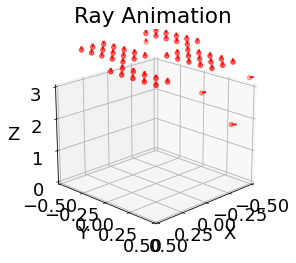

In [44]:
############################### animate rays ##################################
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-test_lim, test_lim)
ax.set_ylim3d(-test_lim, test_lim)
ax.set_zlim3d(0, 3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Ray Animation')
ax.view_init(elev=20, azim=45)
ax.plot_surface(X1, X2, X3, color='b', alpha=0.2)
# define ray animation function
def drawframe(i):
    ax.clear()
    ax.set_xlim3d(-test_lim, test_lim)
    ax.set_ylim3d(-test_lim, test_lim)
    ax.set_zlim3d(0, 3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Ray Animation')
    ax.view_init(elev=20, azim=45)
    ax.plot_surface(X1, X2, X3, color='b', alpha=0.2)
    ax.scatter(rayAnim[i][:,0], rayAnim[i][:,1], rayAnim[i][:,2], color='r', marker='o')
    for j in range(np.size(rayAnim[i][:,0])):
        ax.quiver(rayAnim[i][j,0], rayAnim[i][j,1], rayAnim[i][j,2], rayAnim[i][j,3], rayAnim[i][j,4], rayAnim[i][j,5], length=0.1, normalize=True, color='r')
    return ax

# create animation
anim = animation.FuncAnimation(fig, drawframe, frames=len(rayAnim), interval=50, blit=False)
# save animation
anim.save('rayAnimationA.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

Below is the animation for the ray hitting the surface A. The video is also saved as rayAnimationA.mp4. Reload the markdown cell to see the video.

<video src="rayAnimationA.mp4" controls="controls" style="max-width: 730px;">
</video>

**Problem 2.4:** Set up the second surface (surface B).

/var/folders/7m/8wrj_0b17ql_1p_x8v4tqdrw0000gn/T/ipykernel_44342/2179773981.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


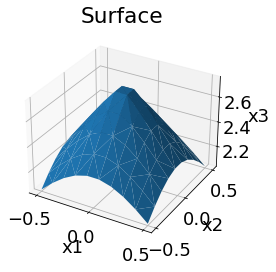

In [45]:
######################### Set up the surface (SURFACE B) ##########################################

# set up limits of test surface
test_lim = 0.5; 

# create grid of points using linspace
x1 = np.linspace(-test_lim,test_lim,10)
x2 = np.linspace(-test_lim,test_lim,10)

# create grid of points using meshgrid
[X1, X2] = np.meshgrid(x1,x2)

# reshape grid into a column vector
X1 = np.reshape(X1,[np.size(X1),1])
X2 = np.reshape(X2,[np.size(X2),1])

# write surface equation for surface a
X3 = np.sqrt((5 - np.sqrt(X1**2 + X2**2))**2 - 4)-1.75 # surface b #FILL IN HERE
      
# Calculate normals

#surface A
#delF
delGx1 = 1/(2*np.sqrt((5 - np.sqrt(X1**2 + X2**2))**2 - 4))*2*(5 - np.sqrt(X1**2 + X2**2))*-1/(2*np.sqrt(X1**2 + X2**2))*2*X1 #FILL IN HERE
delGx2 = 1/(2*np.sqrt((5 - np.sqrt(X1**2 + X2**2))**2 - 4))*2*(5 - np.sqrt(X1**2 + X2**2))*-1/(2*np.sqrt(X1**2 + X2**2))*2*X2 #FILL IN HERE

delFx1 = delGx1
delFx2 = delGx2
delFx3 = np.ones([np.size(delGx1),1])*-1

gradF = np.hstack([delFx1, delFx2, delFx3])
magdelF = np.reshape(np.linalg.norm(gradF,2,1),(np.size(X1),1))

normal = - gradF / magdelF        
   
# plot surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(X1[:,0], X2[:,0], X3[:,0], linewidth=0.2, antialiased=True)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
# label plot
plt.title('Surface')
plt.show()

**Problem 2.5:** Use Forward Euler time-stepping scheme to simulate a beam hitting the given test surfaces. (surface B).

In [50]:
########################## Create rays ##########################################

beam_initvel = np.array([0,0,-c]) #initial velocity of beam
beam_N = 100 #number of rays
beam_initH = 4 #initial height
beam_N = round(np.sqrt(beam_N))**2 # updated number of rays to have it square
print('Updated number of rays is:',beam_N)

#full beam grid
[beam_posx1,  beam_posx2] = np.meshgrid(np.linspace(-0.5,0.5,round(np.sqrt(beam_N))),np.linspace(-0.5,0.5,round(np.sqrt(beam_N)))) 

# reshape grid into a column vector
beam_posx1 = np.reshape(beam_posx1,[np.size(beam_posx1),1]) 
beam_posx2 = np.reshape(beam_posx2,[np.size(beam_posx2),1])
beam_posx3 = np.ones([beam_N,1]) * beam_initH

# set up initial velocity of beam
beam_vel1 = np.ones([beam_N,1])  * beam_initvel[0]
beam_vel2 = np.ones([beam_N,1])  * beam_initvel[1]
beam_vel3 = np.ones([beam_N,1])  * beam_initvel[2]

# Time-stepping
totaltime = 0.000000015 # simulation time
xi = 0.00000005 # time-stepping constant
dt = xi * beam_initH / np.sqrt(c) # time-step
Ntimestep = round(totaltime / dt) # number of time-steps

# initialize variables
IR = np.zeros([np.size(beam_posx1),1]) 
theta_i = np.zeros([np.size(beam_posx1),1])
X1_final = np.empty([np.size(beam_posx1),1])
X2_final = np.empty([np.size(beam_posx1),1])
X3_final = np.empty([np.size(beam_posx1),1])

# initialize animation variables
rayAnim = list() # list of ray objects
rayHit = list() # list of ray hit objects


for i in range(Ntimestep): # time-stepping loop
    
    #time-step announcer (every 100 time-steps)
    if i % 100 == 0:
        print('Time-step:',i,'/',Ntimestep)
        
    
    #update position
    beam_posx1 = beam_posx1 + beam_vel1 * dt
    beam_posx2 = beam_posx2 + beam_vel2 * dt
    beam_posx3 = beam_posx3 + beam_vel3 * dt
     
    for k in range(np.size(beam_posx1)): # loop over rays
        #check if below surface
        X3_calc = np.sqrt((5 - np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))**2 - 4) - 1.75; #FILL IN HERE

        if beam_posx1[k] <= test_lim and beam_posx1[k] >= -test_lim and beam_posx2[k] <= test_lim and beam_posx2[k] >= -test_lim: # if within test limits
           if X3_calc>beam_posx3[k]: # if below surface
               if IR[k] == 0: # if not yet reflected
                    
                    # find normal and ray velocity vector
                    # Calculate normals
                    # delF
                    # surface a
                    delGx1 = 1/(2*np.sqrt((5 - np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))**2 - 4))*2*(5 - np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))*-1/(2*np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))*2*beam_posx1[k] #FILL IN HERE
                    delGx2 = 1/(2*np.sqrt((5 - np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))**2 - 4))*2*(5 - np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))*-1/(2*np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))*2*beam_posx2[k] #FILL IN HERE

                    
                    delFx1 = delGx1
                    delFx2 = delGx2
                    delFx3 = -1
                    
                    gradF = np.hstack([delFx1, delFx2, delFx3])
                    magdelF = np.linalg.norm(gradF,2)
                    
                    normal = - gradF / magdelF

                            
                    norm_k = normal # normal vector
                    beam_vel = np.hstack([beam_vel1[k], beam_vel2[k], beam_vel3[k]]) # ray velocity vector
                    theta_i = np.arccos(np.dot(norm_k,beam_vel)/c) # angle of incidence
                    if beam_vel3[k] <= 0: # if ray is going down
                        #record point of contact with surface
                        X1_final[k] = beam_posx1[k] 
                        X2_final[k] = beam_posx2[k]
                        X3_final[k] = beam_posx3[k]
                    
                        beam_vel = beam_vel - 2 * c * np.cos(theta_i) * norm_k # reflect ray

                        #update velocity
                        beam_vel1[k] = beam_vel[0]
                        beam_vel2[k] = beam_vel[1]
                        beam_vel3[k] = beam_vel[2]
                        #theta_i = np.pi - theta_i

                        #update IR
                        IR[k] = (np.abs(theta_i/n_hat) <= 1.)* \
                            (0.5*(((n_hat**2 * np.cos(theta_i) - (n_hat**2 - np.sin(theta_i)**2)**(0.5))/ \
                                    (n_hat**2 * np.cos(theta_i) + (n_hat**2 - np.sin(theta_i)**2)**(0.5)))**2 +\
                                   (((np.cos(theta_i) - (n_hat**2 - np.sin(theta_i)**2)**(0.5))/ \
                                     (np.cos(theta_i) + (n_hat**2 - np.sin(theta_i)**2)**(0.5)))**2)))+ \
                                (np.abs(theta_i/n_hat) > 1.)**1.



    if i % 50  == 0:
  
        #assign current loc, vel, and energy left in rays in an array

        rayInfo = np.hstack([beam_posx1, beam_posx2, beam_posx3, beam_vel1, beam_vel2, beam_vel3])

        # write into rayAnim list the current x,y,z positions of each ray and velocity vector
        rayAnim.append(rayInfo)

Updated number of rays is: 100
Time-step: 0 / 1299
Time-step: 100 / 1299
Time-step: 200 / 1299
Time-step: 300 / 1299
Time-step: 400 / 1299
Time-step: 500 / 1299
Time-step: 600 / 1299
Time-step: 700 / 1299
Time-step: 800 / 1299
Time-step: 900 / 1299
Time-step: 1000 / 1299
Time-step: 1100 / 1299
Time-step: 1200 / 1299


/var/folders/7m/8wrj_0b17ql_1p_x8v4tqdrw0000gn/T/ipykernel_44342/663805771.py:54: RuntimeWarning: invalid value encountered in sqrt
  X3_calc = np.sqrt((5 - np.sqrt(beam_posx1[k]**2 + beam_posx2[k]**2))**2 - 4) - 1.75; #surface b


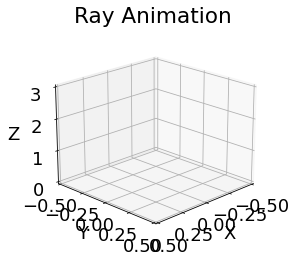

In [51]:
############################### animate rays ##################################
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-test_lim, test_lim)
ax.set_ylim3d(-test_lim, test_lim)
ax.set_zlim3d(0, 4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Ray Animation')
ax.view_init(elev=20, azim=45)
ax.plot_surface(X1, X2, X3, color='b', alpha=0.2)
# define ray animation function
def drawframe(i):
    ax.clear()
    ax.set_xlim3d(-test_lim, test_lim)
    ax.set_ylim3d(-test_lim, test_lim)
    ax.set_zlim3d(0, 3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Ray Animation')
    ax.view_init(elev=20, azim=45)
    ax.plot_surface(X1, X2, X3, color='b', alpha=0.2)
    ax.scatter(rayAnim[i][:,0], rayAnim[i][:,1], rayAnim[i][:,2], color='r', marker='o')
    for j in range(np.size(rayAnim[i][:,0])):
        ax.quiver(rayAnim[i][j,0], rayAnim[i][j,1], rayAnim[i][j,2], rayAnim[i][j,3], rayAnim[i][j,4], rayAnim[i][j,5], length=0.1, normalize=True, color='r')
    return ax

# create animation
anim = animation.FuncAnimation(fig, drawframe, frames=len(rayAnim), interval=50, blit=False)
# save animation
anim.save('rayAnimationB.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

Below is the animation for the ray hitting the surface B. The video is also saved as rayAnimationB.mp4. Reload the markdown cell to see the video.

<video src="rayAnimationB.mp4" controls="controls" style="max-width: 730px;">
</video>

### **Problem 3:** Analyzing Your Results ###  
Answer the following questions about the code you created.

**Problem 3.1:** Discuss your observations from the raytracing animations. *Hint: When do the rays impact the surface? Does the time step capture the reflections properly? etc.*  

**ANSWER:** We see that the rays hit the surface around 1.75 z height for surface A and around 2 z height for surface B. The time step captures the reflections properly as we see the rays bouncing off the surface. The time step is small enough to capture the reflections properly. (Other student answers may vary)

**Problem 3.2:** Try using different time-steps to observe the effect on ray reflections. Report any findings.


**ANSWER:** We see that the time step is small enough to capture the reflections properly. But if we increase the time step, the reflections may be detected at a smaller height and be inaccurate, if we were to plot the detected height vs. the actual height. When we make the time step smaller, the reflections are more accurate, but the simulation takes longer to run. (Other student answers may vary)

Use the following variable glossary to fill in the required variables.

<img src="VariableGlossary.png" width="800" />